In [1]:
%pip install sentence_transformers
%pip install spacy
%pip install matplotlib
%pip install seaborn 
%pip install matplotlib
%pip install scipy
%pip install langchain
import spacy

# Download the English language model 'en_core_web_sm'
spacy.cli.download("en_core_web_sm")

# Load the downloaded model
nlp = spacy.load("en_core_web_sm")


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.1 MB/s eta 0:00:0000:0100:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [15]:
from Bio import Entrez

In [16]:
import pandas as pd
import numpy as np


In [17]:
def search(query, mindate, maxdate):
    #docs: https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch
    Entrez.email = 'example2@email.com'
    handle = Entrez.esearch(db='pubmed',
                            sort='relevance',
                            retmax='10000',
                            retmode='xml',
                            term=query, 
                            mindate=mindate, 
                            maxdate=maxdate)
    results = Entrez.read(handle)
    return results

In [18]:
from datetime import datetime, timedelta
import time
delay_seconds = 1
result_dicts = {}
start_date = datetime(2023, 8, 1)  # get a couple of last observations
end_date = datetime(2023, 11, 1)
window_duration = timedelta(days=30) #assuming 30 days per month and 2 months to be fine
current_date = start_date

# Loop over time windows of 2 months
while current_date < end_date:
    # Calculate the end of the 1-month window
    window_end = current_date + window_duration
    try:
        returned_dicts = search('Intelligence', current_date.strftime('%Y/%m/%d'), window_end.strftime('%Y/%m/%d'))
    except: 
        print(f"Error: query unsuccessful. currdate = {current_date}, window = {window_end}")
        break
        
    #accumulate dictionary values
    for key, value in returned_dicts.items():
        if key in result_dicts:
            if isinstance(value, list):
                if isinstance(result_dicts[key], list):
                    # If both are lists, extend the existing list with the new list
                    result_dicts[key].extend(value)
                else:
                    # If the existing value is not a list, create a new list with both values
                    result_dicts[key] = [result_dicts[key]] + value
            else:
                if isinstance(result_dicts[key], list):
                    # If the existing value is a list, append the new value to it
                    result_dicts[key].append(value)
                else:
                    # If neither is a list, create a list with both values
                    result_dicts[key] = [result_dicts[key], value]
        else:
            # Add the key-value pair to result_dicts
            result_dicts[key] = value
    print(f"current date processed:{current_date}")
    current_date = window_end

current date processed:2023-08-01 00:00:00
current date processed:2023-08-31 00:00:00
current date processed:2023-09-30 00:00:00
current date processed:2023-10-30 00:00:00


In [19]:
studiesIdList = result_dicts['IdList']

In [20]:
len(studiesIdList)

13421

In [21]:
def fetch_details(id_list):
    ids = ','.join(id_list)
    Entrez.email = 'email2@example.com'
    handle = Entrez.efetch(db='pubmed',
    retmode='xml',
    id=ids)
    try:
        results = Entrez.read(handle)
    except Exception as e:
        print(f"Error parsing XML: {e}")
    finally:
        handle.close()
    return results

for item in studiesIdList: 
    try: 
        fetch_details([item])
        print(f"success at:{item}")
    except:
        print(f"error at item:{item}")

In [22]:
title_list = []
authors_list = []
affiliation_list = []
abstract_list = []
journal_list = []
language_list = []
pubdate_year_list = []
pubdate_month_list = []
major_descriptor_list = []
descriptor_list = []
major_qualifier_list = []
qualifier_list = []

studies = fetch_details(studiesIdList)
chunk_size = 500 #reduce chunksize to not exceed request limits
for chunk_i in range(0, len(studiesIdList), chunk_size):
    chunk = studiesIdList[chunk_i:chunk_i + chunk_size]
    papers = fetch_details(chunk)
    for i, paper in enumerate (papers['PubmedArticle']):
        title_list.append(paper['MedlineCitation']['Article']['ArticleTitle'])
        try:
            abstract_list.append(paper['MedlineCitation']['Article']['Abstract']['AbstractText'][0])
        except:
            abstract_list.append('NA')
        try: 
            journal_list.append(paper['MedlineCitation']['Article']['Journal']['Title'])
        except: 
            journal_list.append('NA')
        try:
            language_list.append(paper['MedlineCitation']['Article']['Language'][0])
        except: 
            language_list.append('NA')
        try: 
            descr = [descriptor['DescriptorName'] for descriptor in paper['MedlineCitation']['MeshHeadingList']] 
            descriptor_list.append(descr)
        except: 
            descriptor_list.append("NA")
        try:
            mdescr = [descriptor['DescriptorName'] for descriptor in paper['MedlineCitation']['MeshHeadingList'] if descriptor['DescriptorName'].attributes.get('MajorTopicYN') == 'Y']
            major_descriptor_list.append(mdescr)
        except: 
            major_descriptor_list.append('NA')
        try: 
            qualif = [str(descriptor['QualifierName'][0]) for descriptor in paper['MedlineCitation']['MeshHeadingList'] if descriptor['QualifierName']]
            qualifier_list.append(list(set(qualif))) #append only unique qualifiers
        except: 
            qualifier_list.append('NA')
        try: 
            maj_qualif = [str(descriptor['QualifierName'][0]) for descriptor in paper['MedlineCitation']['MeshHeadingList'] if descriptor['QualifierName'] and descriptor['QualifierName'].attributes.get('MajorTopicYN') == 'Y']
            major_qualifier_list.append(list(set(maj_qualif))) #only unique
        except: 
            major_qualifier_list.append('NA')
        try: 
            authors_list.append([", ".join([author.get('LastName'), author.get('ForeName')]) for author in paper['MedlineCitation']['Article']['AuthorList']])
        except: 
            authors_list.append('NA')
        try: 
            affiliation_lst = []
            for i, author in enumerate(paper['MedlineCitation']['Article']['AuthorList']):
                try:
                    affiliation_lst.append([affiliation.get('Affiliation', '') for affiliation in author.get('AffiliationInfo')][0])
                except: continue
            affiliation_list.append(affiliation_lst)
        except:
            affiliation_list.append('NA')
        try:
            pubdate_year_list.append(paper['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']['Year'])
        except:
            pubdate_year_list.append('NA')
        try:
            pubdate_month_list.append(paper['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']['Month'])
        except:
            pubdate_month_list.append('NA')
            

In [23]:
df = pd.DataFrame(list(zip(
            title_list, authors_list, affiliation_list, qualifier_list, major_qualifier_list, descriptor_list, major_descriptor_list, abstract_list, journal_list, language_list, pubdate_year_list, pubdate_month_list
            )),
            columns=[
            'Title', 'Authors', 'Affiliations', 'Qualifier', 'Major Qualifier', 'Descriptor', 'Major Descriptor','Abstract', 'Journal', 'Language', 'Year','Month'
            ])

In [24]:
df

,Title,Authors,Affiliations,Qualifier,Major Qualifier,Descriptor,Major Descriptor,Abstract,Journal,Language,Year,Month
0,The projection-specific signals that establish...,"[Terauchi, Akiko, Yee, Patricia, Johnson-Venka...","[Department of Neurology, F.M. Kirby Neurobiol...",[],[],"[Animals, Mice, Corpus Striatum, Dopamine, Mes...","[Corpus Striatum, Dopamine]",Dopaminergic projections regulate various brai...,Cell,eng,2023,Aug
1,Open science.,"[Bertram, Michael G, Sundin, Josefin, Roche, D...","[Department of Wildlife, Fish, and Environment...",[],[],"[Humans, Publishing, Motivation, Research Pers...","[Publishing, Motivation]",The term 'open science' refers to a range of m...,Current biology : CB,eng,2023,Aug
2,Intrinsic dopamine and acetylcholine dynamics ...,"[Krok, Anne C, Maltese, Marta, Mistry, Pratik,...","[Neuroscience Institute, New York University G...","[cytology, metabolism]",NA,"[Animals, Mice, Acetylcholine, Action Potentia...","[Acetylcholine, Corpus Striatum, Dopamine]",External rewards such as food and money are po...,Nature,eng,2023,Sep
3,Intelligent Soft Sensors.,"[Tomažič, Simon]","[Faculty of Electrical Engineering, University...",NA,NA,NA,NA,"In this Special Issue, we embark on a journey ...","Sensors (Basel, Switzerland)",eng,2023,Aug
4,Is cancer an intelligent species?,"[Nicolazzo, Chiara, Francescangeli, Federica, ...","[Department of Molecular Medicine, Sapienza Un...",NA,NA,NA,NA,Some relevant emerging properties of intellige...,Cancer metastasis reviews,eng,2023,Dec
...,...,...,...,...,...,...,...,...,...,...,...,...
13408,Evaluation of the US COVID-19 Scenario Modelin...,"[Howerton, Emily, Contamin, Lucie, Mullany, Lu...","[The Pennsylvania State University, University...","[prevention & control, epidemiology]",NA,"[Humans, COVID-19, Pandemics, SARS-CoV-2, Unce...",[COVID-19],Our ability to forecast epidemics far into the...,Nature communications,eng,2023,Nov
13409,14 examples of how LLMs can transform material...,"[Jablonka, Kevin Maik, Ai, Qianxiang, Al-Fegha...","[Laboratory of Molecular Simulation (LSMO), In...",NA,NA,NA,NA,Large-language models (LLMs) such as GPT-4 cau...,Digital discovery,eng,2023,Oct
13410,Brain Growth Charts for Quantitative Analysis ...,NA,[From the Lifespan Brain Institute (LiBI) of t...,"[diagnostic imaging, methods]",NA,"[Humans, Male, Child, Infant, Newborn, Retrosp...","[Growth Charts, Brain]",Background Clinically acquired brain MRI scans...,Radiology,eng,2023,Oct
13411,Potential impact of annual vaccination with re...,"[Jung, Sung-Mok, Loo, Sara L, Howerton, Emily,...","[University of North Carolina at Chapel Hill, ...",NA,NA,NA,NA,COVID-19 continues to cause significant hospit...,medRxiv : the preprint server for health sciences,eng,2023,Nov


In [364]:
test_abstract = df["Abstract"][3]

In [374]:
count_dots = df[df['Abstract'].str.contains('\.\.\.')]
count_dots

,Title,Authors,Affiliations,Qualifier,Major Qualifier,Descriptor,Major Descriptor,Abstract,Journal,Language,Year,Month
3,Intelligent Soft Sensors.,"[Tomažič, Simon]","[Faculty of Electrical Engineering, University...",NA,NA,NA,NA,"In this Special Issue, we embark on a journey ...","Sensors (Basel, Switzerland)",eng,2023,Aug
71,Advanced Topics and Smart Systems for Wireless...,"[Mansour, Ali, Aggoune, Hadi, Moy, Christophe,...","[LABSTICC UMR CNRS 6285, ENSTA-Bretagne, 29806...",NA,NA,NA,NA,Telecommunication has shaped our civilization ...,"Sensors (Basel, Switzerland)",eng,2023,Aug
72,Intelligent Industrial Process Control Systems.,"[Grobelna, Iwona]","[Institute of Automatic Control, Electronics a...",NA,NA,NA,NA,The widespread realization of Industry 4 [...].,"Sensors (Basel, Switzerland)",eng,2023,Aug
230,Sensor Fusion and Advanced Controller for Conn...,"[Li, Boyuan, Wang, Yafei, Papaioannou, Georgio...",[Research Centre for Intelligent Transportatio...,NA,NA,NA,NA,"Nowadays, intelligent vehicles are equipped wi...","Sensors (Basel, Switzerland)",eng,2023,Aug
1336,Rehabilitation for Musculoskeletal Disorders: ...,"[Favre, Julien, Cantaloube, Alexis, Jolles, Br...","[Swiss BioMotion Lab, Lausanne University Hosp...",NA,NA,NA,NA,According to the World Health Organization (WH...,Journal of clinical medicine,eng,2023,Aug
1567,Correction: Tang et al. Vitamin K2 Modulates M...,"[Tang, Hengfang, Zheng, Zhiming, Wang, Han, Wa...","[Institute of Intelligent Machines, Hefei Inst...",NA,NA,NA,NA,In the original publication [...].,Nutrients,eng,2023,Aug
3190,Emerging Sensor Communication Network-Based AI...,"[Sharma, Bhisham, Koundal, Deepika, Ramadan, R...",[Chitkara University Institute of Engineering ...,NA,NA,NA,NA,"At present, the field of the Internet of Thing...","Sensors (Basel, Switzerland)",eng,2023,Sep
3762,"Special Issue: ""Intelligent Systems for Clinic...","[Sannino, Giovanna, Celesti, Antonio, De Falco...",[Institute for High-Performance Computing and ...,NA,NA,NA,NA,The year 2020 was definitely like no other [...].,"Sensors (Basel, Switzerland)",eng,2023,Sep
4502,"Special Issue ""Clinical Frontiers in Percutane...","[Beijk, Marcel A M]","[Department of Cardiology, Amsterdam Universit...",NA,NA,NA,NA,"In the last decade, significant advancements h...",Journal of clinical medicine,eng,2023,Sep
4563,Correction: Mäkynen et al. Wearable Devices Co...,"[Mäkynen, Marko, Ng, G Andre, Li, Xin, Schlind...","[School of Engineering, University of Leiceste...",NA,NA,NA,NA,The authors wish to add two authors to the ori...,"Sensors (Basel, Switzerland)",eng,2023,Sep


df.to_csv("/Users/Kenneth/PycharmProjects/pubMedNLP/kedronlp/data/01_raw/extract_test.csv", index=False)

In [365]:
str(test_abstract)

'In this Special Issue, we embark on a journey into the exciting field of intelligent soft sensors, and take a deep dive into the groundbreaking advances and potential that these software algorithms have introduced in various fields [...].'

In [83]:
[str(sent) for sent in doc.sents]


[
    'Dopaminergic projections regulate various brain functions and are implicated in many neuropsychiatric disorders.',
    'There are two anatomically and functionally distinct dopaminergic projections connecting the midbrain to striatum: nigrostriatal, which controls movement, and mesolimbic, which regulates motivation.',
    'However, how these discrete dopaminergic synaptic connections are established is unknown.',
    'Through an unbiased search, we identify that two groups of antagonistic TGF-β family members, bone morphogenetic protein (BMP)6/BMP2 and transforming growth factor (TGF)-β2, regulate dopaminergic synapse development of nigrostriatal and mesolimbic neurons, respectively.',
    'Projection-preferential expression of their receptors contributes to specific synapse development.',
    'Downstream, Smad1 and Smad2 are specifically activated and required for dopaminergic synapse development and function in nigrostriatal vs. mesolimbic projections.',
    'Remarkably, Sma

In [43]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("pritamdeka/S-PubMedBert-MS-MARCO")
embeddings = model.encode(sentences)
print(embeddings.shape)

(9, 768)


In [170]:
sentences

.

In [108]:
import spacy
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("pritamdeka/S-PubMedBert-MS-MARCO")


In [3]:
test_abstract = df["Abstract"][2]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 test_abstract = df["Abstract"][2]                                                            │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'df' is not defined

In [ ]:
def process(text: str):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(str(text))
    sents = [str(sent) for sent in doc.sents]
    embeddings = model.encode(sents)
    return list(doc.sents), embeddings

def cluster_text(sents, vecs, threshold):
    clusters = [[0]]
    for i in range(1, len(sents)):
        print(cosine_similarity(vecs[i].reshape(1, -1), vecs[i-1].reshape(1, -1)))
        if cosine_similarity(vecs[i].reshape(1, -1), vecs[i-1].reshape(1, -1)) < threshold:
            clusters.append([])
        clusters[-1].append(i)
    
    return clusters

def clean_text(text):
    # Add your text cleaning process here
    return text

In [215]:

# Initialize the clusters lengths list and final texts list
clusters_lens = []
final_texts = []

# Process parameters
initial_threshold = 0.92
max_iterations = 5

#text to be chunked
sents, vecs = process(test_abstract)

# Cluster the sentences
clusters = cluster_text(sents, vecs, initial_threshold)

for cluster in clusters:
    iterations = 0
    while iterations < max_iterations:
        cluster_txt = clean_text(' '.join([sents[i].text for i in cluster]))
        cluster_len = len(cluster_txt)
        print(cluster_len)

        # Check if the cluster is too short
        if cluster_len < 180:
            new_threshold = max(initial_threshold - 0.1 * iterations, 0.7)

        # Check if cluster too large
        elif cluster_len > 600:
                new_threshold = min(0.95, initial_threshold + 0.1 * iterations)
        else:
            break  # If the cluster size is within the desired range, exit the loop

        reclusters = cluster_text(sents, vecs, new_threshold)
        cluster = [i for subcluster in reclusters for i in subcluster]

        iterations +=1
        
    clusters_lens.append(cluster_len)
    final_texts.append(cluster_txt)

[[0.9311791]]
[[0.9205222]]
[[0.91777414]]
681
[[0.9311791]]
[[0.9205222]]
[[0.91777414]]
861
[[0.9311791]]
[[0.9205222]]
[[0.91777414]]
861
[[0.9311791]]
[[0.9205222]]
[[0.91777414]]
861
[[0.9311791]]
[[0.9205222]]
[[0.91777414]]
861
[[0.9311791]]
[[0.9205222]]
[[0.91777414]]
179
[[0.9311791]]
[[0.9205222]]
[[0.91777414]]
861
[[0.9311791]]
[[0.9205222]]
[[0.91777414]]
861
[[0.9311791]]
[[0.9205222]]
[[0.91777414]]
861
[[0.9311791]]
[[0.9205222]]
[[0.91777414]]
861
[[0.9311791]]
[[0.9205222]]
[[0.91777414]]


In [216]:
final_texts


[
    "The term 'open science' refers to a range of methods, tools, platforms and practices that aim to make scientific research more accessible, transparent, reproducible and reliable. This includes, for example, sharing code, data and research materials, embracing new publishing formats such as registered reports and preprints, pursuing replication studies and reanalyses, optimising statistical approaches to improve evidence assessment and re-evaluating institutional incentives. The ongoing shift towards open science practices is partly due to mounting evidence that studies across disciplines suffer from biases, underpowered designs and irreproducible or non-replicable results. It also stems from a general desire amongst many researchers to reduce hyper-competitivity in science and instead promote collaborative research that benefits science and society.",
    "The term 'open science' refers to a range of methods, tools, platforms and practices that aim to make scientific research m

In [2]:
def process(text: str):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(str(text))
    sents = [str(sent) for sent in doc.sents]
    embeddings = model.encode(sents)
    return list(doc.sents), embeddings

def cluster_text(sents, vecs, threshold):
    clusters = [[0]]
    for i in range(1, len(sents)):
        if cosine_similarity(vecs[i].reshape(1, -1), vecs[i-1].reshape(1, -1)) < threshold:
            clusters.append([])
        clusters[-1].append(i)
    return clusters


# Initialize the clusters lengths list and final texts list
clusters_lens = []
final_texts = []

# Process the chunk
initial_threshold = 0.8
max_iteration = 5
sents, vecs = process(test_abstract)

# Cluster the sentences
clusters = cluster_text(sents, vecs, initial_threshold)

for cluster in clusters:
    cluster_txt = ' '.join([sents[i].text for i in cluster])
    cluster_len = len(cluster_txt)
    print(f"cluster_txt: {cluster_txt}")

    
    # Check if the cluster is too long
    if cluster_len > 700:
        iterator = 1
        # Track the best subcluster lengths
        best_num_paragraphs = 500 #initialize with a large value
        best_div_texts = [] 
        while cluster_len > 700:
            div_lens = []
            div_texts = []
            len_collector = []
            threshold = min(initial_threshold+(0.02*iterator), 0.95)
            sents_div, vecs_div = process(cluster_txt)
            reclusters = cluster_text(sents_div, vecs_div, threshold)

            for subcluster in reclusters:
                div_txt = ' '.join([sents_div[i].text for i in subcluster])
                div_len = len(div_txt)
                len_collector.append(div_len)
                print(f"div_len: {div_len}")

                if div_len > 60 and div_len < 800:
                    div_lens.append(div_len)
                    div_texts.append(div_txt)
                
                cluster_len = max(len_collector)
                
            
            """#pick the clustering into as few clusters as possible
            if len(div_lens) < best_num_paragraphs and len(div_lens)>0:
                best_div_texts = div_texts
                best_num_paragraphs = len(div_lens)"""

            iterator+=1
            
            print(f"div_lens {iterator}: {div_lens}")
            #print(f"best_div_lens {iterator}: {best_num_paragraphs}")
            
        clusters_lens.extend(div_lens) #best_div_lens
        final_texts.extend(div_texts)  #best_div_texts
            
    else:
        clusters_lens.append(cluster_len)
        final_texts.append(cluster_txt)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:24                                                                                   │
│                                                                                                  │
│   21 # Process the chunk                                                                         │
│   22 initial_threshold = 0.8                                                                     │
│   23 max_iteration = 5                                                                           │
│ ❱ 24 sents, vecs = process(test_abstract)                                                        │
│   25                                                                                             │
│   26 # Cluster the sentences                                                                     │
│   27 clusters = cluster_text(sents, vecs, initial_threshold)                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'test_abstract' is not defined

In [348]:
sum([88, 421, 140, 100, 252, 351, 134, 198])

1684

In [362]:
for text in final_texts: 
    print(len(text))

88
421
140
100
252
351
134
198


In [363]:
final_texts


[
    'External rewards such as food and money are potent modifiers of behaviour<sup>1,2</sup>.',
    'Pioneering studies established that these salient sensory stimuli briefly interrupt the tonic discharge of neurons that produce the neuromodulators dopamine (DA) and acetylcholine (ACh): midbrain DA neurons (DANs) fire a burst of action potentials that broadly elevates DA in the striatum<sup>3,4</sup> at the same time that striatal cholinergic interneurons (CINs) produce a characteristic pause in firing<sup>5,6</sup>.',
    'These phasic responses are thought to create unique, temporally limited conditions that motivate action and promote learning<sup>7-11</sup>.',
    'However, the dynamics of DA and ACh outside explicitly rewarded situations remain poorly understood.',
    'Here we show that extracellular DA and ACh levels fluctuate spontaneously and periodically at a frequency of approximately 2\u2009Hz in the dorsal\xa0striatum of mice and maintain the same temporal relationship 

In [311]:
docss = nlp("The term 'open science' refers to a range of methods, tools, platforms and practices that aim to make scientific research more accessible, transparent, reproducible and reliable. This includes, for example, sharing code, data and research materials, embracing new publishing formats such as registered reports and preprints, pursuing replication studies and reanalyses, optimising statistical approaches to improve evidence assessment and re-evaluating institutional incentives. The ongoing shift towards open science practices is partly due to mounting evidence that studies across disciplines suffer from biases, underpowered designs and irreproducible or non-replicable results. It also stems from a general desire amongst many researchers to reduce hyper-competitivity in science and instead promote collaborative research that benefits science and society.")
paragraphs = [paragraph.text.strip() for paragraph in docss.sents if paragraph.text.strip()]
paragraphs


[
    "The term 'open science' refers to a range of methods, tools, platforms and practices that aim to make scientific research more accessible, transparent, reproducible and reliable.",
    'This includes, for example, sharing code, data and research materials, embracing new publishing formats such as registered reports and preprints, pursuing replication studies and reanalyses, optimising statistical approaches to improve evidence assessment and re-evaluating institutional incentives.',
    'The ongoing shift towards open science practices is partly due to mounting evidence that studies across disciplines suffer from biases, underpowered designs and irreproducible or non-replicable results.',
    'It also stems from a general desire amongst many researchers to reduce hyper-competitivity in science and instead promote collaborative research that benefits science and society.'
]

In [302]:
len(best_div_lens)

0

In [ ]:
  if cluster_len < 180:
        iterator = 1
        while iterator < max_iteration: 
            threshold = min(initial_threshold-0.1*iterator, 0.7)
            sents_div, vecs_div = process(cluster_txt)
            reclusters = cluster_text(sents_div, vecs_div, threshold)

            for subcluster in reclusters:
                div_txt = clean_text(' '.join([sents_div[i].text for i in subcluster]))
                div_len = len(div_txt)

                if div_len > 60 or div_len < 700:
                    clusters_lens.append(div_len)
                    final_texts.append(div_txt)
                    continue
                else: 
                    iterator+=1
                    break

In [296]:
clusters_lens

[178, 299, 202, 179]

In [308]:
final_texts


[
    "The term 'open science' refers to a range of methods, tools, platforms and practices that aim to make scientific research more accessible, transparent, reproducible and reliable. This includes, for example, sharing code, data and research materials, embracing new publishing formats such as registered reports and preprints, pursuing replication studies and reanalyses, optimising statistical approaches to improve evidence assessment and re-evaluating institutional incentives. The ongoing shift towards open science practices is partly due to mounting evidence that studies across disciplines suffer from biases, underpowered designs and irreproducible or non-replicable results.",
    'It also stems from a general desire amongst many researchers to reduce hyper-competitivity in science and instead promote collaborative research that benefits science and society.'
]

In [171]:
sents, embeds = process(test_abstract)

In [124]:
np.dot(vecs[1], vecs[2])

207.00006

In [128]:
sents


[
    Dopaminergic projections regulate various brain functions and are implicated in many neuropsychiatric disorders.,
    There are two anatomically and functionally distinct dopaminergic projections connecting the midbrain to striatum: nigrostriatal, which controls movement, and mesolimbic, which regulates motivation.,
    However, how these discrete dopaminergic synaptic connections are established is unknown.,
    Through an unbiased search, we identify that two groups of antagonistic TGF-β family members, bone morphogenetic protein (BMP)6/BMP2 and transforming growth factor (TGF)-β2, regulate dopaminergic synapse development of nigrostriatal and mesolimbic neurons, respectively.,
    Projection-preferential expression of their receptors contributes to specific synapse development.,
    Downstream, Smad1 and Smad2 are specifically activated and required for dopaminergic synapse development and function in nigrostriatal vs. mesolimbic projections.,
    Remarkably, Smad1 mutant mic

In [158]:
import pandas as pd
import numpy as np
# Library to import pre-trained model for sentence embeddings
from sentence_transformers import SentenceTransformer
# Calculate similarities between sentences
from sklearn.metrics.pairwise import cosine_similarity
# Visualization library
import seaborn as sns
import matplotlib.pyplot as plt
# package for finding local minimas
from scipy.signal import argrelextrema
import math

In [168]:
len(embeddings)

9

Text(0.5, 1.0, 'Cosine similarities matrix')

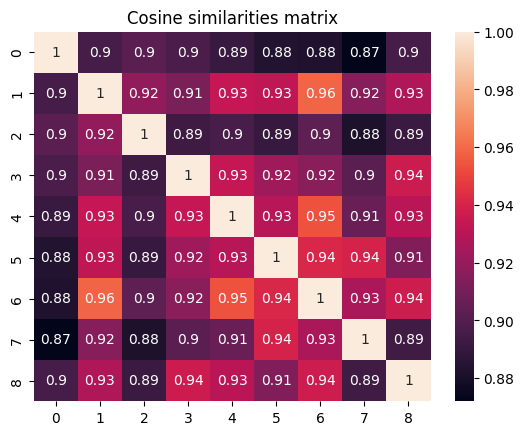

In [332]:
similarities = cosine_similarity(vecs)
sns.heatmap(similarities,annot=True).set_title('Cosine similarities matrix')

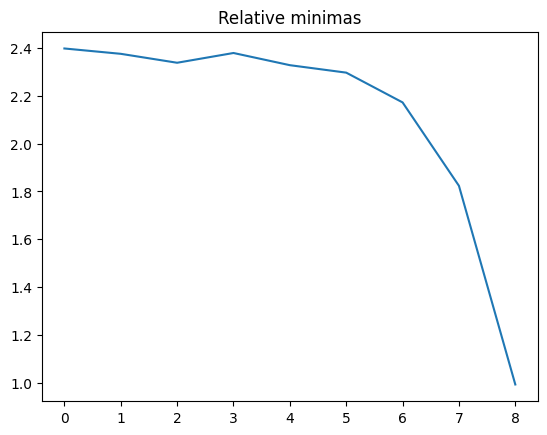

In [162]:
def rev_sigmoid(x:float)->float:
    return (1 / (1 + math.exp(0.5*x)))
    
def activate_similarities(similarities:np.array, p_size=10)->np.array:
        """ Function returns list of weighted sums of activated sentence similarities
        Args:
            similarities (numpy array): it should square matrix where each sentence corresponds to another with cosine similarity
            p_size (int): number of sentences are used to calculate weighted sum 
        Returns:
            list: list of weighted sums
        """
        # To create weights for sigmoid function we first have to create space. P_size will determine number of sentences used and the size of weights vector.
        x = np.linspace(-10,10,p_size)
        # Then we need to apply activation function to the created space
        y = np.vectorize(rev_sigmoid) 
        # Because we only apply activation to p_size number of sentences we have to add zeros to neglect the effect of every additional sentence and to match the length ofvector we will multiply
        activation_weights = np.pad(y(x),(0,similarities.shape[0]-p_size))
        ### 1. Take each diagonal to the right of the main diagonal
        diagonals = [similarities.diagonal(each) for each in range(0,similarities.shape[0])]
        ### 2. Pad each diagonal by zeros at the end. Because each diagonal is different length we should pad it with zeros at the end
        diagonals = [np.pad(each, (0,similarities.shape[0]-len(each))) for each in diagonals]
        ### 3. Stack those diagonals into new matrix
        diagonals = np.stack(diagonals)
        ### 4. Apply activation weights to each row. Multiply similarities with our activation.
        diagonals = diagonals * activation_weights.reshape(-1,1)
        ### 5. Calculate the weighted sum of activated similarities
        activated_similarities = np.sum(diagonals, axis=0)
        return activated_similarities
  
# Lets apply our function. For long sentences i reccomend to use 10 or more sentences
activated_similarities = activate_similarities(similarities, p_size=5)

# lets create empty fig for our plor
fig, ax = plt.subplots()
### 6. Find relative minima of our vector. For all local minimas and save them to variable with argrelextrema function
minmimas = argrelextrema(activated_similarities, np.less, order=2) #order parameter controls how frequent should be splits. I would not reccomend changing this parameter.
# plot the flow of our text with activated similarities
sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax).set_title('Relative minimas');
# Now lets plot vertical lines in order to see where we created the split
plt.vlines(x=minmimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1, label='vline_multiple - full height')

In [44]:

#Get the order number of the sentences which are in splitting points
split_points = [each for each in minmimas[0]]
# Create empty string
text = ''
for num,each in enumerate(sentences):
    # Check if sentence is a minima (splitting point)
    if num in split_points:
        # If it is than add a dot to the end of the sentence and a paragraph before it.
        text+=f'\n\n {each}. '
    else:
        # If it is a normal sentence just add a dot to the end and keep adding sentences.
        text+=f'{each}. '

In [46]:
split_points

[]

In [47]:
test_abstract

'Dopaminergic projections regulate various brain functions and are implicated in many neuropsychiatric disorders. There are two anatomically and functionally distinct dopaminergic projections connecting the midbrain to striatum: nigrostriatal, which controls movement, and mesolimbic, which regulates motivation. However, how these discrete dopaminergic synaptic connections are established is unknown. Through an unbiased search, we identify that two groups of antagonistic TGF-β family members, bone morphogenetic protein (BMP)6/BMP2 and transforming growth factor (TGF)-β2, regulate dopaminergic synapse development of nigrostriatal and mesolimbic neurons, respectively. Projection-preferential expression of their receptors contributes to specific synapse development. Downstream, Smad1 and Smad2 are specifically activated and required for dopaminergic synapse development and function in nigrostriatal vs. mesolimbic projections. Remarkably, Smad1 mutant mice show motor defects, whereas Smad2 


[
    'Dopaminergic projections regulate various brain functions and are implicated in many neuropsychiatric disorders',
    'There are two anatomically and functionally distinct dopaminergic projections connecting the midbrain to striatum: nigrostriatal, which controls movement, and mesolimbic, which regulates motivation',
    'However, how these discrete dopaminergic synaptic connections are established is unknown',
    'Through an unbiased search, we identify that two groups of antagonistic TGF-β family members, bone morphogenetic protein (BMP)6/BMP2 and transforming growth factor (TGF)-β2, regulate dopaminergic synapse development of nigrostriatal and mesolimbic neurons, respectively',
    'Projection-preferential expression of their receptors contributes to specific synapse development',
    'Downstream, Smad1 and Smad2 are specifically activated and required for dopaminergic synapse development and function in nigrostriatal vs',
    'mesolimbic projections',
    'Remarkably, Sma